In [1]:
import tensorflow as tf
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from util import *
from load_data import load_input_file, build_combined_input
from NN_train import *
path_tosave = 'Models/V05_ChargeSplit_Optimize'
n_epochs = 100
mkdir_p(path_tosave)
features_to_ignore = []
#features_to_ignore = ["DPhill_SS"]
features_to_ignore = ["DeltaR_min_lep_bjet77", "DRll01","HT_jets","sumPsbtag","met_met","Mll01","DEtall_SS","jet_pseudoscore_DL1r2","nJets_OR_DL1r_77","sumPsbtag77"]

In [2]:
#samples, feature_names, class_names, class_no = load_input_file('data/sstt_multiclass_background_V03.h5', features_to_ignore)
samples, feature_names, class_names, class_no = load_input_file('data/V05_sstt_Data.h5', features_to_ignore)
input_features, targets, class_labels, weights = build_combined_input(samples)

Ignoring feature:  DeltaR_min_lep_bjet77
Ignoring feature:  DRll01
Ignoring feature:  HT_jets
Ignoring feature:  sumPsbtag
Ignoring feature:  met_met
Ignoring feature:  Mll01
Ignoring feature:  DEtall_SS
Ignoring feature:  jet_pseudoscore_DL1r2
Ignoring feature:  nJets_OR_DL1r_77
Ignoring feature:  sumPsbtag77
Found 21 features on the dataset 11 features were loaded: 

DPhill_SS
HT_lep
MtLepMet
jet_pseudoscore_DL1r0
jet_pseudoscore_DL1r1
DeltaR_max_lep_bjet77
DRjj_lead
jet_pt0_nofwd
total_charge
nJets_OR
randomRunNumber
 
Dataset contains extra labels for different backgrounds!
Class 0  :  253953
Class 1  :  231587
Class 2  :  3249
Class 3  :  310859
Class 4  :  190589
Class 5  :  223033
Class 6  :  355647
Class 7  :  109991
Class 8  :  1039
Class 9  :  0
Class 10  :  425286
Dataset contains 679239 Signal events and 1425994 Background events.


In [3]:
Number = np.squeeze((input_features[:,-1]).astype(int))
Phi = input_features[:,0]
#Number = np.arange(0,1679947)
feature_names = feature_names[1:-1]
input_features = input_features[:,1:-1]

In [4]:
index_sort = np.argsort(class_no)
class_names = (np.array(class_names)[index_sort])
class_no = np.sort(class_no)
print(class_names)
print(class_no)
No_Classes = class_no.max()+1

['signal' 'ttZ' 'tty' 'ttW' 'tttt' 'ttH' 'Other' 'Diboson' 'Fakes'
 'signaltbartbar']
[ 0  1  2  3  4  5  6  7  8 10]


In [5]:
# Drop out total charge in the Inputlist
total_charge = input_features[:,7]
input_features = np.delete(input_features, 7, 1)
feature_names.remove('total_charge')

In [6]:
# True -> 2 Positiv | False -> 2 Negative
boolean_charge = np.zeros([total_charge.shape[0]])
boolean_charge[total_charge == 2] = True
boolean_charge[total_charge == 254] = False

In [7]:
boolean_charge = (boolean_charge-0.5)*4

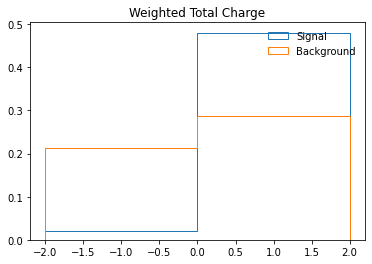

In [8]:
plt.title(str("Weighted Total Charge"))
plt.hist(boolean_charge[targets==1], bins=2, range=(-2, 2), weights=weights[targets==1], histtype='step', label='Signal', density=True)
plt.hist(boolean_charge[targets==0], bins=2, range=(-2, 2), weights=weights[targets==0], histtype='step', label='Background', density=True)
plt.legend(frameon=False)

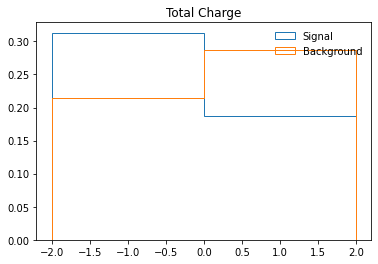

In [9]:
plt.title(str("Total Charge"))
plt.hist(boolean_charge[targets==1], bins=2, range=(-2, 2), histtype='step', label='Signal', density=True)
plt.hist(boolean_charge[targets==0], bins=2, range=(-2, 2), histtype='step', label='Background', density=True)
plt.legend(frameon=False)

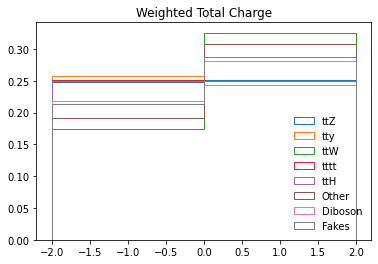

<Figure size 432x288 with 0 Axes>

In [10]:
plt.title(str("Weighted Total Charge"))
for i in range(class_no.shape[0]):
    if i == 0:
        continue
    if i == 9:
        continue
    plt.hist(boolean_charge[class_labels==class_no[i]], bins=2, range=(-2, 2), weights=weights[class_labels==class_no[i]], histtype='step', density=True, label=class_names[i])
plt.legend(frameon=False, loc='lower right')
plt.show()
plt.clf()

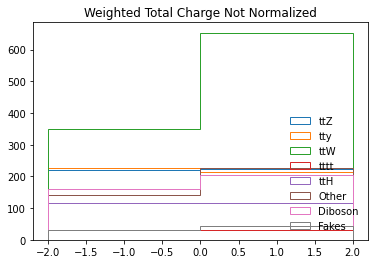

<Figure size 432x288 with 0 Axes>

In [11]:
plt.title(str("Weighted Total Charge Not Normalized"))
for i in range(class_no.shape[0]):
    if i == 0:
        continue
    if i == 9:
        continue
    plt.hist(boolean_charge[class_labels==class_no[i]], bins=2, range=(-2, 2), weights=weights[class_labels==class_no[i]], histtype='step', label=class_names[i])
plt.legend(frameon=False, loc='lower right')
plt.show()
plt.clf()

In [12]:
ScaleWeights(targets,weights)
#scale the input between 0-1
scaler = StandardScaler().fit(input_features)
input_scaled = scaler.transform(input_features)
pickle.dump(scaler, open(path_tosave + '/scaler.pkl','wb'))


======Weight Statistic========================================
Weights::        W(1)=1200.48, W(0)=2983.69
Scaled weights:: W(1)=1.05262e+06, W(0)=1.05262e+06


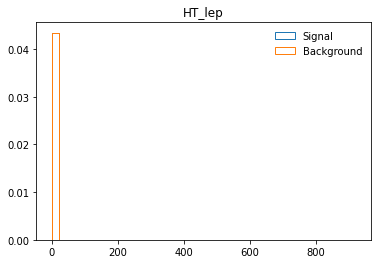

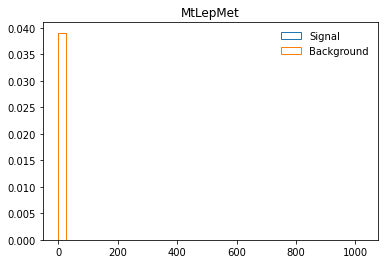

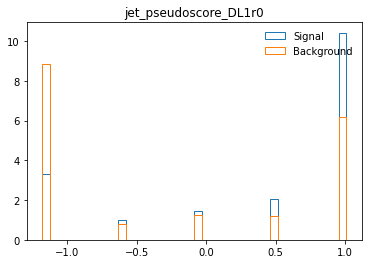

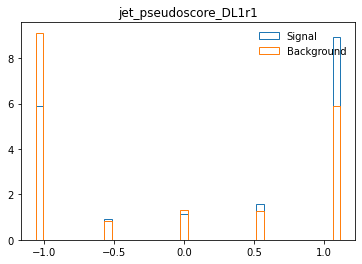

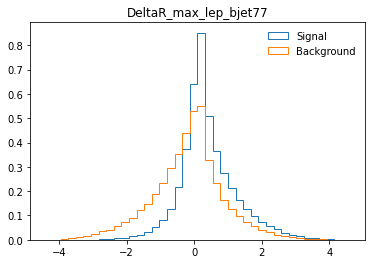

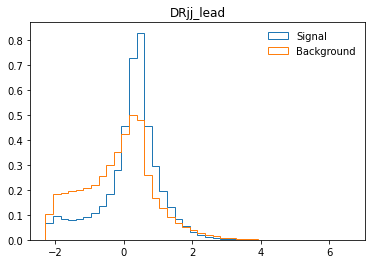

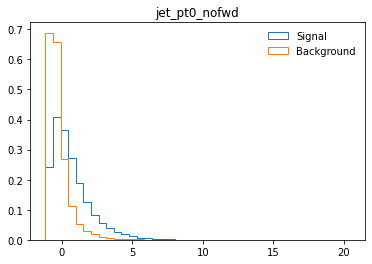

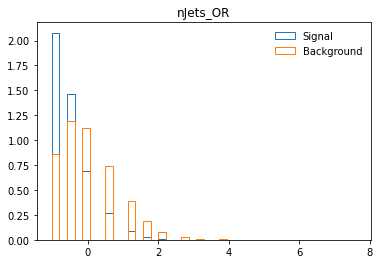

In [13]:
for i in range(input_scaled.shape[1]):
    max_val = input_scaled[:,i].max()
    min_val = input_scaled[:,i].min()
    plt.title(str(feature_names[i]))
    cqu = plt.hist(input_scaled[:,i][targets==1], bins=40, weights=weights[targets==1], range=(min_val, max_val), histtype='step', label='Signal', density=True)
    cuu = plt.hist(input_scaled[:,i][targets==0], bins=40, weights=weights[targets==0], range=(min_val, max_val), histtype='step', label='Background', density=True)
    plt.legend(frameon=False)
    save_name = path_tosave + "/Input_Feature_" + str(i) + ".png"
    plt.savefig(save_name)
    plt.show()

In [14]:
#Split into ++/pos and --/neg

# ++
input_scaled_pos = input_scaled[boolean_charge > 0]
targets_pos = targets[boolean_charge > 0]
weights_pos = weights[boolean_charge > 0]
class_labels_pos = class_labels[boolean_charge > 0]
Number_pos = Number[boolean_charge > 0]
# --
input_scaled_neg = input_scaled[boolean_charge < 0]
targets_neg = targets[boolean_charge < 0]
weights_neg = weights[boolean_charge < 0]
class_labels_neg = class_labels[boolean_charge < 0]
Number_neg = Number[boolean_charge < 0]

In [15]:
print("Ratio of Signal wrt to xs for ++ events: ", np.round(weights_pos[targets_pos==1].sum() / weights_pos.sum(),3)*100,"%")

Ratio of Signal wrt to xs for ++ events:  62.6 %


In [16]:
print("Ratio of Signal wrt to xs for -- events: ", np.round(weights_neg[targets_neg==1].sum() / weights_neg.sum(),3)*100,"%")

Ratio of Signal wrt to xs for -- events:  8.5 %


In [17]:
#Preprocess
odd_pos, even_pos = Fold_Odd_Even(input_scaled_pos, targets_pos, weights_pos, class_labels_pos, Number_pos)
odd_neg, even_neg = Fold_Odd_Even(input_scaled_neg, targets_neg, weights_neg, class_labels_neg, Number_neg)

#train, val, test = Train_Val_Test_Split(input_scaled, targets, weights, class_labels)
input_shape = odd_pos[0].shape[1]
batch_size = 20000

# Optimize Model Structure

In [45]:
def Train_Odd_Even(odd, even, n_epochs = 400, batch_size = 2000):
    fit_history_list = []
    model_list = []
    input_shape = odd[0].shape[1]

    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lr_step_decay)

    X_odd, X_val_odd, weights_odd, weights_val_odd, y_odd, y_val_odd, = train_test_split(odd[0], odd[2], odd[1], test_size=0.2)
    X_even, X_val_even, weights_even, weights_val_even, y_even, y_val_even, = train_test_split(even[0], even[2], even[1], test_size=0.2)

    model_odd = Create_Model_basic(input_shape)
    model_even = Create_Model_basic(input_shape)
    fit_history_odd = model_odd.fit(X_odd, y_odd, epochs = n_epochs, shuffle = True, batch_size = batch_size, validation_data=(X_val_odd, y_val_odd, weights_val_odd), sample_weight=weights_odd, verbose=0 ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 100, verbose = True, min_delta = 0.001),lr_schedule]) #
    fit_history_even = model_even.fit(X_even, y_even, epochs = n_epochs, shuffle = True, batch_size = batch_size, validation_data=(X_val_even, y_val_even, weights_val_even), sample_weight=weights_even, verbose=0 ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 100, verbose = True, min_delta = 0.001),lr_schedule]) #

    return fit_history_odd, model_odd, fit_history_even, model_even

In [59]:
def Create_Model1(input_shape):
    layer_opts = dict( activation = 'relu', kernel_initializer = initializers.glorot_normal(seed=seed))
    input_layer = Kl.Input(shape = input_shape )
    x = Kl.Dense( 36, **layer_opts) (input_layer)
    x = Kl.Dense( 48, **layer_opts) (x)
    x = Kl.Dense( 48, **layer_opts) (x)
    x = Kl.Dense( 48, **layer_opts) (x)
    y_pred = Kl.Dense( 1., activation = 'sigmoid', name = "OutputLayer" )(x)
    model = Km.Model(inputs= input_layer, outputs=y_pred )
    model_optimizer = Adam(lr=0.0001)
    model.compile(optimizer=tf.keras.optimizers.Adam(),loss='binary_crossentropy', metrics = ['accuracy'])
    model.summary()
    return model

def Create_Model2(input_shape):
    layer_opts = dict( activation = 'relu', kernel_initializer = initializers.glorot_normal(seed=seed))
    input_layer = Kl.Input(shape = input_shape )
    x = Kl.Dense( 128, **layer_opts) (input_layer)
    x = Kl.Dense( 64, **layer_opts) (x)
    x = Kl.Dense( 32, **layer_opts) (x)
    x = Kl.Dense( 16, **layer_opts) (x)
    x = Kl.Dense( 8, **layer_opts) (x)
    y_pred = Kl.Dense( 1., activation = 'sigmoid', name = "OutputLayer" )(x)
    model = Km.Model(inputs= input_layer, outputs=y_pred )
    model_optimizer = Adam(lr=0.0001)
    model.compile(optimizer=tf.keras.optimizers.Adam(),loss='binary_crossentropy', metrics = ['accuracy'])
    model.summary()
    return model

def Create_Model3(input_shape):
    layer_opts = dict( activation = 'relu', kernel_initializer = initializers.glorot_normal(seed=seed))
    input_layer = Kl.Input(shape = input_shape )
    x = Kl.Dense( 128, **layer_opts) (input_layer)
    x = Kl.Dense( 128, **layer_opts) (input_layer)
    x = Kl.Dense( 64, **layer_opts) (x)
    x = Kl.Dense( 32, **layer_opts) (x)
    x = Kl.Dense( 16, **layer_opts) (x)
    x = Kl.Dense( 8, **layer_opts) (x)
    y_pred = Kl.Dense( 1., activation = 'sigmoid', name = "OutputLayer" )(x)
    model = Km.Model(inputs= input_layer, outputs=y_pred )
    model_optimizer = Adam(lr=0.0001)
    model.compile(optimizer=tf.keras.optimizers.Adam(),loss='binary_crossentropy', metrics = ['accuracy'])
    model.summary()
    return model

def Create_Model4(input_shape):
    layer_opts = dict( activation = 'relu', kernel_initializer = initializers.glorot_normal(seed=seed), kernel_regularizer=regularizers.l2(0.001))
    input_layer = Kl.Input(shape = input_shape )
    x = Kl.Dense( 128, **layer_opts) (input_layer)
    x = Kl.Dense( 128, **layer_opts) (input_layer)
    x = Kl.Dense( 64, **layer_opts) (x)
    x = Kl.Dense( 32, **layer_opts) (x)
    x = Kl.Dense( 16, **layer_opts) (x)
    x = Kl.Dense( 8, **layer_opts) (x)
    y_pred = Kl.Dense( 1., activation = 'sigmoid', name = "OutputLayer" )(x)
    model = Km.Model(inputs= input_layer, outputs=y_pred )
    model_optimizer = Adam(lr=0.0001)
    model.compile(optimizer=tf.keras.optimizers.Adam(),loss='binary_crossentropy', metrics = ['accuracy'])
    model.summary()
    return model

In [60]:
def Create_Model_basic(input_shape):
    layer_opts = dict( activation = 'relu', kernel_initializer = initializers.glorot_normal(seed=seed), kernel_regularizer=regularizers.l2(0.0001))
    input_layer = Kl.Input(shape = input_shape )
    x = Kl.Dense( 128, **layer_opts) (input_layer)
    x = Kl.Dense( 128, **layer_opts) (input_layer)
    x = Kl.Dense( 64, **layer_opts) (x)
    x = Kl.Dense( 32, **layer_opts) (x)
    x = Kl.Dense( 16, **layer_opts) (x)
    x = Kl.Dense( 8, **layer_opts) (x)
    y_pred = Kl.Dense( 1., activation = 'sigmoid', name = "OutputLayer" )(x)
    model = Km.Model(inputs= input_layer, outputs=y_pred )
    model_optimizer = Adam(lr=0.0001)
    model.compile(optimizer=tf.keras.optimizers.Adam(),loss='binary_crossentropy', metrics = ['accuracy'])
    model.summary()
    return model

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 8)]               0         
_________________________________________________________________
dense_55 (Dense)             (None, 128)               1152      
_________________________________________________________________
dense_56 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_57 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_58 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_59 (Dense)             (None, 8)                 136       
_________________________________________________________________
OutputLayer (Dense)          (None, 1)                 9  

/home/avdgraaf/.local/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


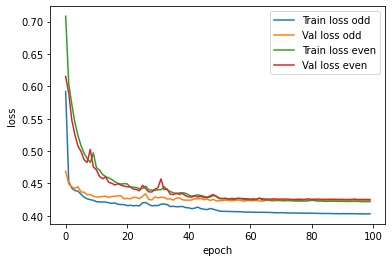

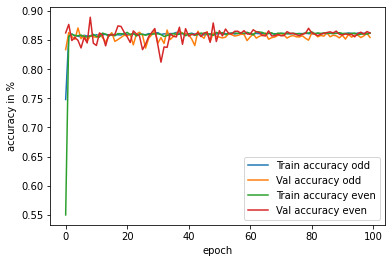

In [61]:
hist_odd_pos, model_odd_pos, hist_even_pos, model_even_pos = Train_Odd_Even(odd_pos, even_pos, n_epochs = n_epochs, batch_size = batch_size)
history_list_pos = [hist_odd_pos, hist_even_pos]
Plot_Metrics_KFold(history_list_pos, path_tosave)

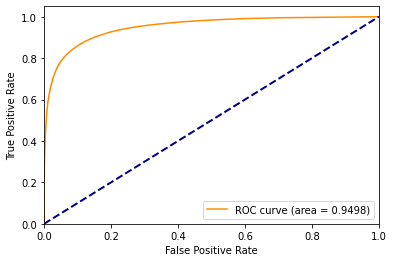

/home/avdgraaf/.local/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


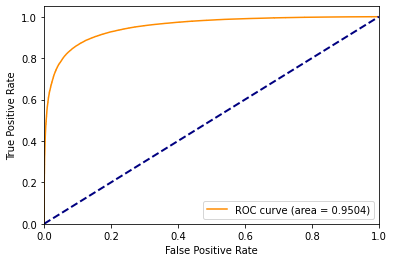

In [62]:
#Model 5
plot_roc_curve(model_even_pos, odd_pos, path_tosave, odd=False)
plot_roc_curve(model_odd_pos, even_pos, path_tosave, odd=True)

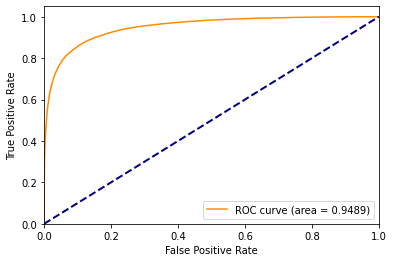

/home/avdgraaf/.local/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


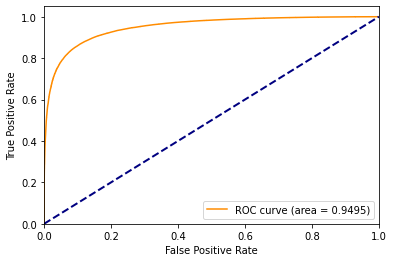

In [58]:
#Model 4
plot_roc_curve(model_even_pos, odd_pos, path_tosave, odd=False)
plot_roc_curve(model_odd_pos, even_pos, path_tosave, odd=True)

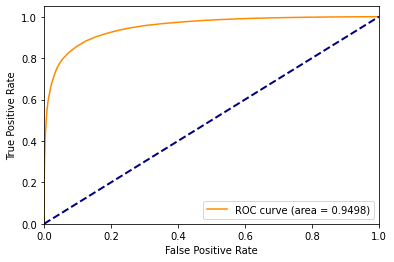

/home/avdgraaf/.local/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


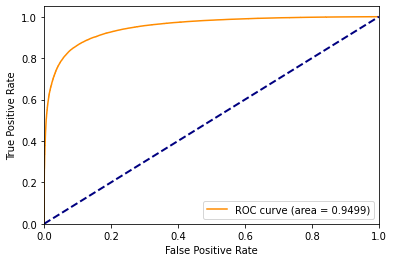

In [55]:
#Model 3
plot_roc_curve(model_even_pos, odd_pos, path_tosave, odd=False)
plot_roc_curve(model_odd_pos, even_pos, path_tosave, odd=True)

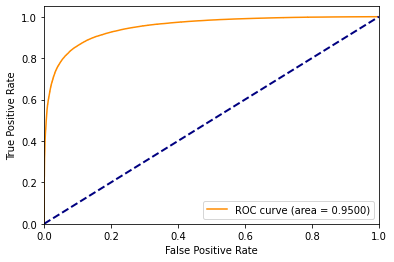

/home/avdgraaf/.local/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


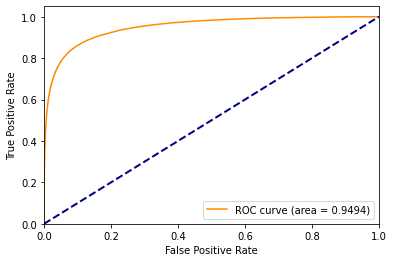

In [52]:
#Model 2
plot_roc_curve(model_even_pos, odd_pos, path_tosave, odd=False)
plot_roc_curve(model_odd_pos, even_pos, path_tosave, odd=True)

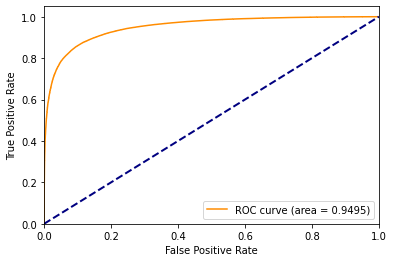

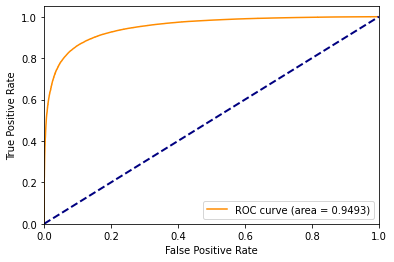

In [49]:
#Model 1
plot_roc_curve(model_even_pos, odd_pos, path_tosave, odd=False)
plot_roc_curve(model_odd_pos, even_pos, path_tosave, odd=True)

# ++ Model

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8)]               0         
_________________________________________________________________
dense (Dense)                (None, 36)                324       
_________________________________________________________________
dense_1 (Dense)              (None, 48)                1776      
_________________________________________________________________
OutputLayer (Dense)          (None, 1)                 49        
Total params: 2,149
Trainable params: 2,149
Non-trainable params: 0
_________________________________________________________________
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 8)]               0         
__________________________________________

/home/avdgraaf/.local/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


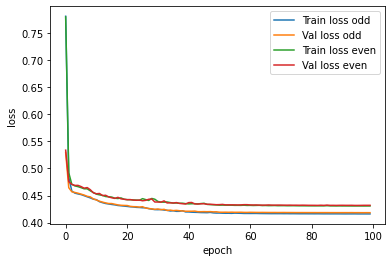

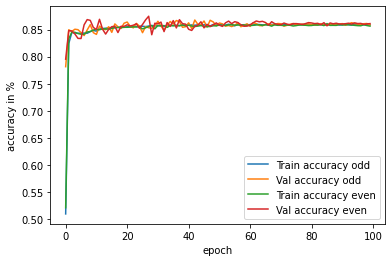

Saving architecture to: /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_ChargeSplit_Optimize/architecture_odd_pos.json
Saving weights to     : /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_ChargeSplit_Optimize/weights_odd_pos.h5
Saving architecture to: /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_ChargeSplit_Optimize/architecture_even_pos.json
Saving weights to     : /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_ChargeSplit_Optimize/weights_even_pos.h5


In [18]:
hist_odd_pos, model_odd_pos, hist_even_pos, model_even_pos = Train_Odd_Even(odd_pos, even_pos, n_epochs = n_epochs, batch_size = batch_size)
history_list_pos = [hist_odd_pos, hist_even_pos]
Plot_Metrics_KFold(history_list_pos, path_tosave)
Save_Model(model_odd_pos, path_tosave, "_odd_pos")
Save_Model(model_even_pos, path_tosave, "_even_pos")

# -- Model

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 8)]               0         
_________________________________________________________________
dense_4 (Dense)              (None, 36)                324       
_________________________________________________________________
dense_5 (Dense)              (None, 48)                1776      
_________________________________________________________________
OutputLayer (Dense)          (None, 1)                 49        
Total params: 2,149
Trainable params: 2,149
Non-trainable params: 0
_________________________________________________________________
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 8)]               0         
________________________________________

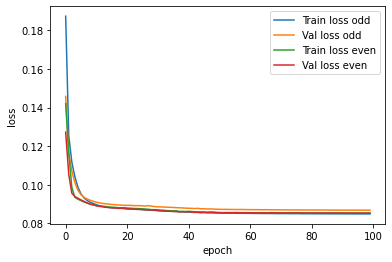

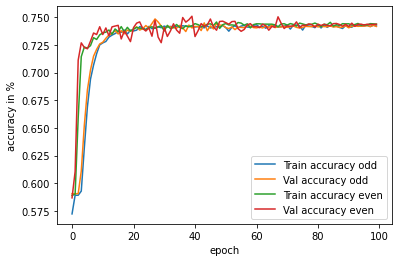

Saving architecture to: /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_ChargeSplit_Optimize/architecture_odd_neg.json
Saving weights to     : /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_ChargeSplit_Optimize/weights_odd_neg.h5
Saving architecture to: /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_ChargeSplit_Optimize/architecture_even_neg.json
Saving weights to     : /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_ChargeSplit_Optimize/weights_even_neg.h5


In [19]:
hist_odd_neg, model_odd_neg, hist_even_neg, model_even_neg = Train_Odd_Even(odd_neg, even_neg, n_epochs = n_epochs, batch_size = batch_size)
history_list_neg = [hist_odd_neg, hist_even_neg]
Plot_Metrics_KFold(history_list_neg, path_tosave)
Save_Model(model_odd_neg, path_tosave, "_odd_neg")
Save_Model(model_even_neg, path_tosave, "_even_neg")

# Evaluation

In [20]:
model_odd_neg = Load_Model(path_tosave, name="_odd_neg")
model_even_neg = Load_Model(path_tosave, name="_even_neg")
model_odd_pos = Load_Model(path_tosave, name="_odd_pos")
model_even_pos = Load_Model(path_tosave, name="_even_pos")

Loading model architecture and weights (/mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_ChargeSplit_Optimize/architecture_odd_neg.json, /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_ChargeSplit_Optimize/weights_odd_neg.h5)
Loading model architecture and weights (/mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_ChargeSplit_Optimize/architecture_even_neg.json, /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_ChargeSplit_Optimize/weights_even_neg.h5)
Loading model architecture and weights (/mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_ChargeSplit_Optimize/architecture_odd_pos.json, /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_ChargeSplit_Optimize/weights_odd_pos.h5)
Loading model architecture and weights (/mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_ChargeSplit_Optimize/architecture_even_pos.json, /mnt/c/Users/aaron/Deskto

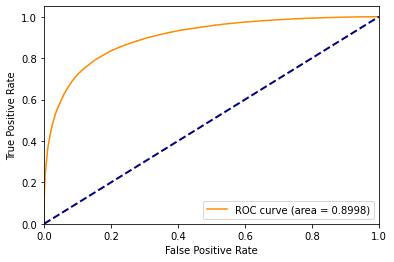

/home/avdgraaf/.local/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


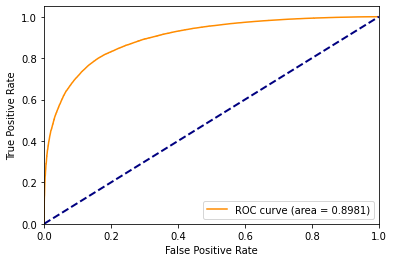

In [21]:
plot_roc_curve(model_even_neg, odd_neg, path_tosave, odd=False)
plot_roc_curve(model_odd_neg, even_neg, path_tosave, odd=True)

/home/avdgraaf/.local/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


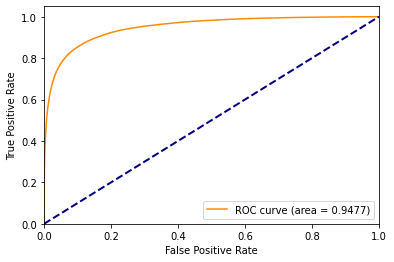

/home/avdgraaf/.local/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


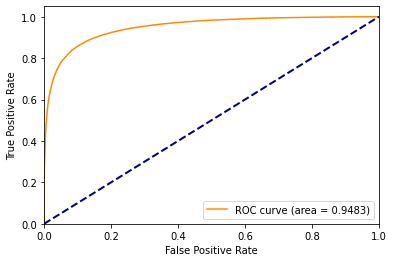

In [22]:
plot_roc_curve(model_even_pos, odd_pos, path_tosave, odd=False)
plot_roc_curve(model_odd_pos, even_pos, path_tosave, odd=True)

In [23]:
pred1 = model_even_pos.predict(odd_pos[0])
pred2 = model_odd_pos.predict(even_pos[0])
pred3 = model_even_neg.predict(odd_neg[0])
pred4 = model_odd_neg.predict(even_neg[0])

truth1 = odd_pos[1]
truth2 = even_pos[1]
truth3 = odd_neg[1]
truth4 = even_neg[1]

weights1 = odd_pos[2]
weights2 = even_pos[2]
weights3 = odd_neg[2]
weights4 = even_neg[2]

pred = np.concatenate([pred1, pred2, pred3, pred4])
truth = np.concatenate([truth1, truth2, truth3, truth4])
weights = np.concatenate([weights1, weights2, weights3, weights4])

In [24]:
fpr1, tpr1, thr1 = roc_curve(truth1, pred1, sample_weight=weights1)
fpr2, tpr2, thr2 = roc_curve(truth2, pred2, sample_weight=weights2)
fpr3, tpr3, thr3 = roc_curve(truth3, pred3, sample_weight=weights3)
fpr4, tpr4, thr4 = roc_curve(truth4, pred4, sample_weight=weights4)

roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)
roc_auc4 = auc(fpr4, tpr4)

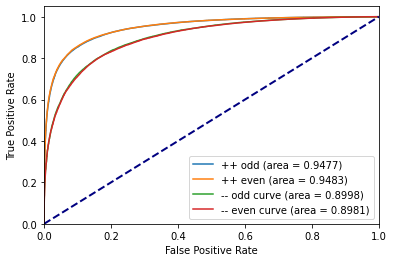

In [25]:
plt.plot(fpr1, tpr1 ,label='++ odd (area = {:.4f})'.format(roc_auc1))
plt.plot(fpr2, tpr2 ,label='++ even (area = {:.4f})'.format(roc_auc2))
plt.plot(fpr3, tpr3 ,label='-- odd curve (area = {:.4f})'.format(roc_auc3))
plt.plot(fpr4, tpr4 ,label='-- even curve (area = {:.4f})'.format(roc_auc4))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

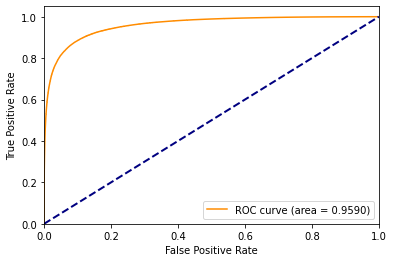

In [26]:
fpr, tpr, thr = roc_curve(truth, pred, sample_weight=weights)
roc_auc = auc(fpr, tpr)
fig = plt.figure()
plt.plot(fpr, tpr, color='darkorange',label='ROC curve (area = {:.4f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [27]:
pred_pos = np.concatenate([pred1, pred2])
truth_pos = np.concatenate([truth1, truth2])
weights_pos = np.concatenate([weights1, weights2])

In [28]:
pred_neg = np.concatenate([pred3, pred4])
truth_neg = np.concatenate([truth3, truth4])
weights_neg = np.concatenate([weights3, weights4])

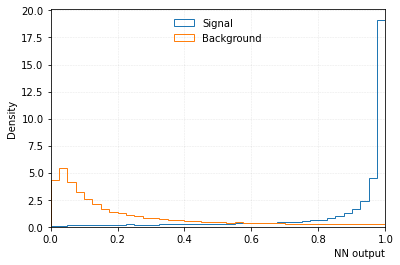

In [29]:
fig = plt.figure()
plt.grid(color='k', which='both', linestyle='--', lw=0.5, alpha=0.1, zorder = 0)
plt.xlabel("NN output", horizontalalignment='right', x=1)
plt.xlim([0,1])
plt.ylabel("Density")
#plt.yscale('log')
histargs = {"bins":40, "range":(0,1.), "density":True, "histtype":'step'}
plt.hist(pred_pos[:,0][truth_pos==1],label = "Signal", **histargs, weights=weights_pos[truth_pos==1])
plt.hist(pred_pos[:,0][truth_pos==0],label = "Background", **histargs, weights=weights_pos[truth_pos==0])
plt.legend(loc='upper center', frameon=False)
plt.show()

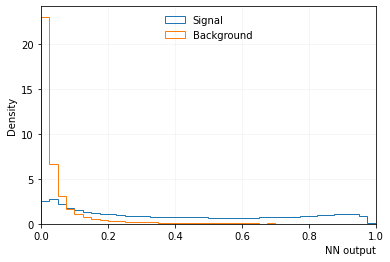

In [30]:
fig = plt.figure()
plt.grid(color='k', which='both', linestyle='--', lw=0.5, alpha=0.1, zorder = 0)
plt.xlabel("NN output", horizontalalignment='right', x=1)
plt.xlim([0,1])
plt.ylabel("Density")
#plt.yscale('log')
histargs = {"bins":40, "range":(0,1.), "density":True, "histtype":'step'}
plt.hist(pred_neg[:,0][truth_neg==1],label = "Signal", **histargs, weights=weights_neg[truth_neg==1])
plt.hist(pred_neg[:,0][truth_neg==0],label = "Background", **histargs, weights=weights_neg[truth_neg==0])
plt.legend(loc='upper center', frameon=False)
plt.show()

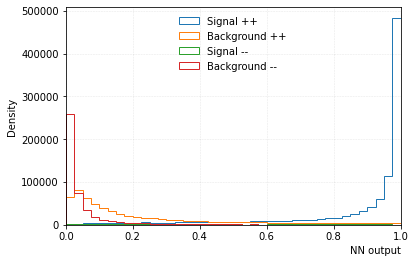

In [31]:
fig = plt.figure()
plt.grid(color='k', which='both', linestyle='--', lw=0.5, alpha=0.1, zorder = 0)
plt.xlabel("NN output", horizontalalignment='right', x=1)
plt.xlim([0,1])
plt.ylabel("Density")
#plt.yscale('log')
histargs = {"bins":40, "range":(0,1.), "histtype":'step'}
plt.hist(pred_pos[:,0][truth_pos==1],label = "Signal ++ ", **histargs, weights=weights_pos[truth_pos==1])
plt.hist(pred_pos[:,0][truth_pos==0],label = "Background ++", **histargs, weights=weights_pos[truth_pos==0])
plt.hist(pred_neg[:,0][truth_neg==1],label = "Signal --", **histargs, weights=weights_neg[truth_neg==1])
plt.hist(pred_neg[:,0][truth_neg==0],label = "Background --", **histargs, weights=weights_neg[truth_neg==0])
plt.legend(loc='upper center', frameon=False)
plt.show()

# Cominbed Model with Charge Information

In [32]:
input_scaled_n_totalcharge = np.concatenate([input_scaled, np.reshape(total_charge, (2105233,1))], axis=1)

In [33]:
odd, even = Fold_Odd_Even(input_scaled_n_totalcharge, targets, weights, class_labels, Number)
#train, val, test = Train_Val_Test_Split(input_scaled, targets, weights, class_labels)
input_shape = odd[0].shape[1]
batch_size = 20000

In [34]:
hist_odd, model_odd, hist_even, model_even = Train_Odd_Even(odd, even, n_epochs = n_epochs, batch_size = batch_size)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 9)]               0         
_________________________________________________________________
dense_8 (Dense)              (None, 36)                360       
_________________________________________________________________
dense_9 (Dense)              (None, 48)                1776      
_________________________________________________________________
OutputLayer (Dense)          (None, 1)                 49        
Total params: 2,185
Trainable params: 2,185
Non-trainable params: 0
_________________________________________________________________
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 9)]               0         
________________________________________

/home/avdgraaf/.local/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


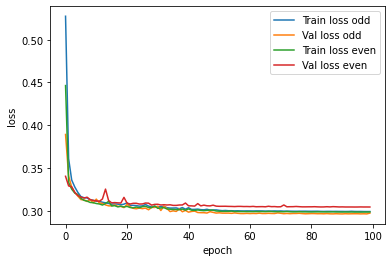

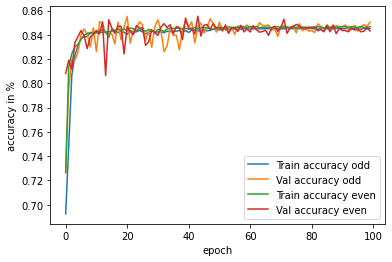

Saving architecture to: /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_ChargeSplit_Optimize/architecture_odd.json
Saving weights to     : /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_ChargeSplit_Optimize/weights_odd.h5
Saving architecture to: /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_ChargeSplit_Optimize/architecture_even.json
Saving weights to     : /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_ChargeSplit_Optimize/weights_even.h5


In [35]:
history_list = [hist_odd, hist_even]
Plot_Metrics_KFold(history_list, path_tosave)
Save_Model(model_odd, path_tosave, "_odd")
Save_Model(model_even, path_tosave, "_even")

In [36]:
model_odd = Load_Model(path_tosave, name="_odd")
model_even = Load_Model(path_tosave, name="_even")

Loading model architecture and weights (/mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_ChargeSplit_Optimize/architecture_odd.json, /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_ChargeSplit_Optimize/weights_odd.h5)
Loading model architecture and weights (/mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_ChargeSplit_Optimize/architecture_even.json, /mnt/c/Users/aaron/Desktop/PhD/Same_Sign_Top/NN_for_sstt/NN/Models/V05_ChargeSplit_Optimize/weights_even.h5)


/home/avdgraaf/.local/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


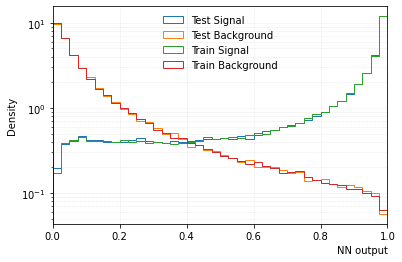

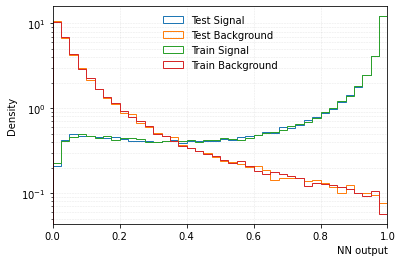

In [37]:
Plot_NN_Output(model_odd, odd, even, path_tosave, True)
Plot_NN_Output(model_even, even, odd, path_tosave, True, False)

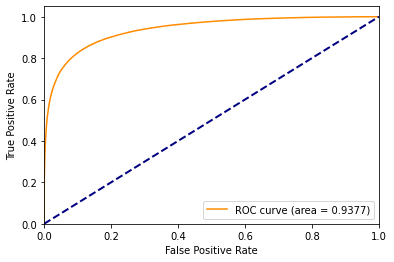

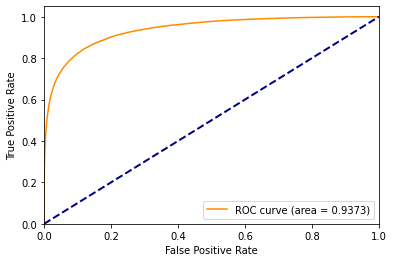

In [38]:
plot_roc_curve(model_even, odd, path_tosave, odd=False)
plot_roc_curve(model_odd, even, path_tosave, odd=True)

In [39]:
pred1 = model_even.predict(odd[0])
pred2 = model_odd.predict(even[0])

In [40]:
truth1 = odd[1]
truth2 = even[1]
weights1 = odd[2]
weights2 = even[2]
pred = np.concatenate([pred1, pred2])
truth = np.concatenate([truth1, truth2])
weights = np.concatenate([weights1, weights2])

In [41]:
fpr1, tpr1, thr1 = roc_curve(truth1, pred1, sample_weight=weights1)
fpr2, tpr2, thr2 = roc_curve(truth2, pred2, sample_weight=weights2)

roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)

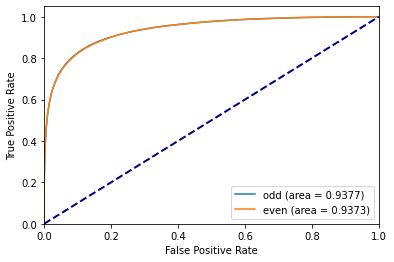

In [42]:
plt.plot(fpr1, tpr1 ,label='odd (area = {:.4f})'.format(roc_auc1))
plt.plot(fpr2, tpr2 ,label='even (area = {:.4f})'.format(roc_auc2))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

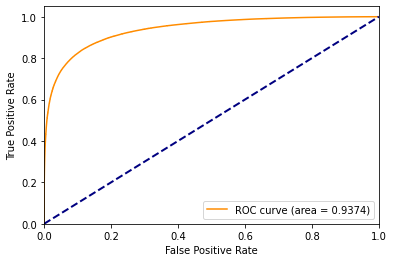

In [43]:
fpr, tpr, thr = roc_curve(truth, pred, sample_weight=weights)
roc_auc = auc(fpr, tpr)
fig = plt.figure()
plt.plot(fpr, tpr, color='darkorange',label='ROC curve (area = {:.4f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()